In [1]:
# Reading gpx file
import gpxpy
import gpxpy.gpx
from IPython import display
from xml.dom import minidom
import math
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from matplotlib import pyplot as plot

gpx = gpxpy.parse(open('June282018Data.gpx'))
track = gpx.tracks[0]
segment = track.segments[0]
data = []

for point_idx, point in enumerate(segment.points):
    data.append([point.longitude, point.latitude, point.elevation, point.time, segment.get_speed(point_idx)])
    
from pandas import DataFrame
columns = ['Longitude', 'Latitude', 'Altitude', 'Time', 'Speed']
Data = DataFrame(data, columns=columns)

# Reading gpx file again to easily plot the track, speed and elevation profile
data=open('June282018Data.gpx')
xmldoc = minidom.parse(data)
track = xmldoc.getElementsByTagName('trkpt')
elevation=xmldoc.getElementsByTagName('ele')
datetime=xmldoc.getElementsByTagName('time')
n_track=len(track)

#Parsing gpx element
lon_list=[]
lat_list=[]
h_list=[]
time_list=[]

for s in range(n_track):
    lon,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
    elev=elevation[s].firstChild.nodeValue
    lon_list.append(float(lon))
    lat_list.append(float(lat))
    h_list.append(float(elev))
    
    # Parsing time element
    dt=datetime[s].firstChild.nodeValue
    time_split=dt.split('T')
    hms_split=time_split[1].split(':')
    time_hour=int(hms_split[0])
    time_minute=int(hms_split[1])
    time_second=float(hms_split[2].split('Z')[0])
    total_second=time_hour*3600+time_minute*60+time_second
    time_list.append(total_second)
    Time = time_list

# Creating Geodetic to cartesian function
def geo2cart(lon,lat,h):
    a=6378137 #WGS 84 Major axis
    b=6356752.3142 #WGS 84 Minor axis
    e2=1-(b**2/a**2)
    N=float(a/math.sqrt(1-e2*(math.sin(math.radians(abs(lat)))**2)))
    X=(N+h)*math.cos(math.radians(lat))*math.cos(math.radians(lon))
    Y=(N+h)*math.cos(math.radians(lat))*math.sin(math.radians(lon))
    return X,Y

#Creating distance function
def distance(x1,y1,x2,y2):
    d=math.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

#creating speed function
def speed(x0,y0,x1,y1,t0,t1):
    d=math.sqrt((x0-x1)**2+(y0-y1)**2)
    delta_t=t1-t0
    s=float(d/delta_t)
    return s

#Populate speed and distance
d_list=[0.0]
speed_list=[0.0]
l=0
for k in range(n_track-1):
    if k<(n_track-1):
        l=k+1
    else:
        l=k
    XY0=geo2cart(lon_list[k],lat_list[k],h_list[k])
    XY1=geo2cart(lon_list[l],lat_list[l],h_list[l])
    
    #DISTANCE
    d=distance(XY0[0],XY0[1],XY1[0],XY1[1])
    sum_d=d+d_list[-1]
    d_list.append(sum_d)
    Distance = np.array(d_list)
    Distance = pd.Series(Distance)
    
    #SPEED
    s=speed(XY0[0],XY0[1],XY1[0],XY1[1],time_list[k],time_list[l])
    speed_list.append(s)
    

# Defining parameters
d = 0.64 # diameter of the tyre in metres
r = 0.08 # rake of the tyre in metres
Mv = 268 # total mass of the vehicle, driver and passenger in kg
Mf = 2*(1/2*Mv*(d/2)**2) # fictive mass of rolling inertia in kg
g = 9.81 # gravitational accerelation in m/s2
F = 0.03; # range (0.02 - 0.04)
lo = 1.226 # air density in kg/m3
Vw = 0 # speed of wind is negligible compared to the speed of the vehicle
Ci = 0.05
dt = 1 #seconds
# Rolling resitance
CRF = 0.03; # range (0.02 - 0.04)
Cx = 0.7  # range (0.6 - 1)
# Projected area of driver and bike
A = 0.5 # meters, assumed (0.5 x 1.5) for front side of the bike and driver
Kigali_Coeff = 0.816 # Average slope coefficient for Kigali city

# Calculating distance
from math import sin, cos, sqrt, atan2, radians, tan
R = 6373 # Radius of the earth in km
Data['Distance'] = (R*np.arccos(np.sin(Data['Latitude'])*np.sin(Data['Latitude'].shift(1)) + np.cos(Data['Latitude'])*np.cos(Data['Latitude'].shift(1))*np.cos(Data['Longitude'] - Data['Longitude'].shift(1)))).fillna(0)

# calculating total distance at every point
new_distance = []
cumsum = 0
size = Data['Distance']
for x in size:
    cumsum += x
    new_distance.append(cumsum)
Data['Cumulative distance'] = new_distance

# inserting time in the data set
Data['Seconds'] = Time

# Calculating linear acceleration
Data['Linear_Acceler'] = (((Data['Speed'] - Data['Speed'].shift(1))/(Data['Seconds'] - Data['Seconds'].shift(1)))).fillna(0)
# calculating angle
Data['Angle'] = np.arctan(Kigali_Coeff)

# Estimating energy consumed
Energy1 = Mv*g*(F*np.cos(Data['Angle'])+np.sin(Data['Angle']))
Energy2 = lo*Cx*A*Data['Speed']*Data['Speed']
Energy3 = Ci*Mv*Data['Linear_Acceler']

# Total Energy
Data['Energy'] = (1/36)*(Energy1+Energy2+Energy3)*Data['Cumulative distance']
Data['Energy_n'] = (1/36)*(Energy1+Energy2+Energy3)*Data['Distance']

# Cleaning the first five rows when motorcycle was at rest
# Data = Data.iloc[5:]
Data = Data[:-40]

# Plotting energy profile again to get better view
plot.figure(num=None, figsize=(15, 8))
plot.plot(Data['Cumulative distance']/1000, Data['Energy']/1000)
plot.title('Energy profile', fontsize=24, color='b')
plot.xlabel('Distance (km)', fontsize=16)
plot.ylabel('Energy Consumed (Wh)', fontsize=16)   
plot.grid()

plot.figure(num=None, figsize=(15, 8))
Data['Energy_n'][Data['Energy_n'] > 100] = 0
plot.plot(Data['Cumulative distance']/1000, Data['Energy_n'])
plot.title('Variation of energy consumption over distance travelled', fontsize=24, color='b')
plot.xlabel('Distance (km)', fontsize=16)
plot.ylabel('Energy Consumed (Wh)', fontsize=16)   
plot.grid()

# Average watt-hour per kilometer
Average_wh_per_km = Data['Energy'].sum()/Data['Cumulative distance'].sum()
Average_wh_per_km 



49.35984601700375

49.461276626399695

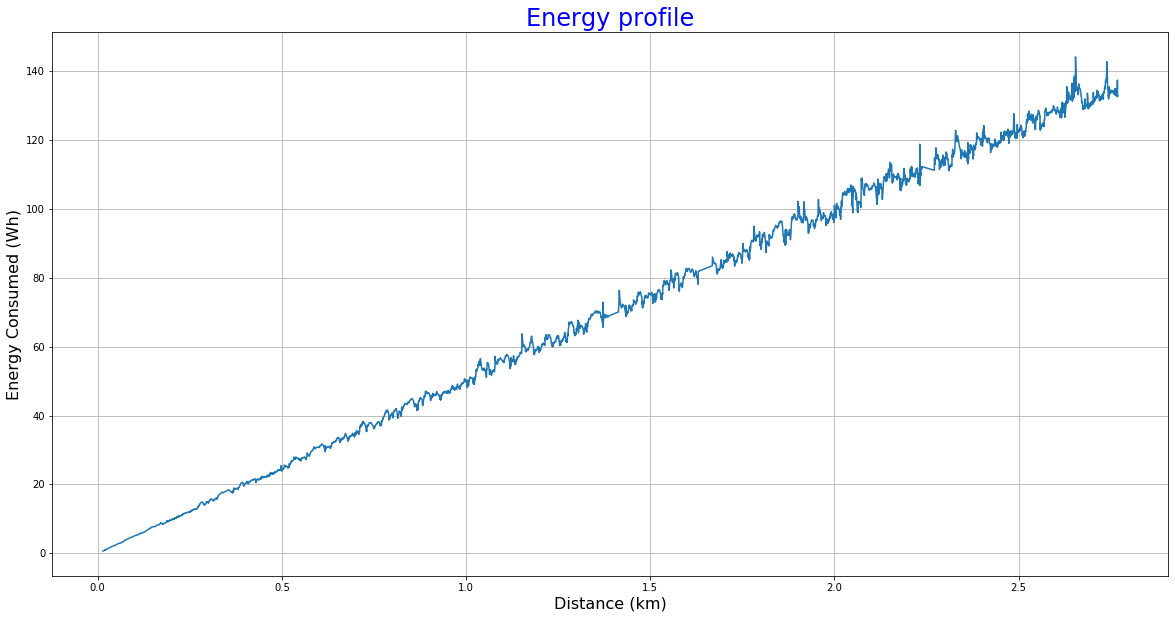

In [6]:
# Electric motorcycle data analytics model built in python
# GPS data  were used 

# Reading gpx file
gpx = gpxpy.parse(open('July082018Data.gpx'))
track = gpx.tracks[0]
segment = track.segments[0]
data = []

for point_idx, point in enumerate(segment.points):
    data.append([point.longitude, point.latitude, point.elevation, point.time, segment.get_speed(point_idx)])
    
from pandas import DataFrame
columns = ['Longitude', 'Latitude', 'Altitude', 'Time', 'Speed']
Data = DataFrame(data, columns=columns)

# Reading gpx file again to easily plot the track, speed and elevation profile
data=open('July082018Data.gpx')
xmldoc = minidom.parse(data)
track = xmldoc.getElementsByTagName('trkpt')
elevation=xmldoc.getElementsByTagName('ele')
datetime=xmldoc.getElementsByTagName('time')
n_track=len(track)

#Parsing gpx element
lon_list=[]
lat_list=[]
h_list=[]
time_list=[]

for s in range(n_track):
    lon,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
    elev=elevation[s].firstChild.nodeValue
    lon_list.append(float(lon))
    lat_list.append(float(lat))
    h_list.append(float(elev))
    
    # Parsing time element
    dt=datetime[s].firstChild.nodeValue
    time_split=dt.split('T')
    hms_split=time_split[1].split(':')
    time_hour=int(hms_split[0])
    time_minute=int(hms_split[1])
    time_second=float(hms_split[2].split('Z')[0])
    total_second=time_hour*3600+time_minute*60+time_second
    time_list.append(total_second)
    Time = time_list

# Creating Geodetic to cartesian function
def geo2cart(lon,lat,h):
    a=6378137 #WGS 84 Major axis
    b=6356752.3142 #WGS 84 Minor axis
    e2=1-(b**2/a**2)
    N=float(a/math.sqrt(1-e2*(math.sin(math.radians(abs(lat)))**2)))
    X=(N+h)*math.cos(math.radians(lat))*math.cos(math.radians(lon))
    Y=(N+h)*math.cos(math.radians(lat))*math.sin(math.radians(lon))
    return X,Y

#Creating distance function
def distance(x1,y1,x2,y2):
    d=math.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

#creating speed function
def speed(x0,y0,x1,y1,t0,t1):
    d=math.sqrt((x0-x1)**2+(y0-y1)**2)
    delta_t=t1-t0
    s=float(d/delta_t)
    return s

#Populate speed and distance
d_list=[0.0]
speed_list=[0.0]
l=0
for k in range(n_track-1):
    if k<(n_track-1):
        l=k+1
    else:
        l=k
    XY0=geo2cart(lon_list[k],lat_list[k],h_list[k])
    XY1=geo2cart(lon_list[l],lat_list[l],h_list[l])
    
    #DISTANCE
    d=distance(XY0[0],XY0[1],XY1[0],XY1[1])
    sum_d=d+d_list[-1]
    d_list.append(sum_d)
    Distance = np.array(d_list)
    Distance = pd.Series(Distance)
    
    #SPEED
    s=speed(XY0[0],XY0[1],XY1[0],XY1[1],time_list[k],time_list[l])
    speed_list.append(s)
    
# Defining parameters
d = 0.64 # diameter of the tyre in metres
r = 0.08 # rake of the tyre in metres
Mv = 268 # total mass of the vehicle, driver and passenger in kg
Mf = 2*(1/2*Mv*(d/2)**2) # fictive mass of rolling inertia in kg
g = 9.81 # gravitational accerelation in m/s2
F = 0.03; # range (0.02 - 0.04)
lo = 1.226 # air density in kg/m3
Vw = 0 # speed of wind is negligible compared to the speed of the vehicle
Ci = 0.05
dt = 1 #seconds
# Rolling resitance
CRF = 0.03; # range (0.02 - 0.04)
Cx = 0.7  # range (0.6 - 1)
# Projected area of driver and bike
A = 0.5 # meters, assumed (0.5 x 1.5) for front side of the bike and driver
Kigali_Coeff = 0.816 # Average slope coefficient for Kigali city

# Calculating distance
from math import sin, cos, sqrt, atan2, radians, tan
R = 6373 # Radius of the earth in km
Data['Distance'] = (R*np.arccos(np.sin(Data['Latitude'])*np.sin(Data['Latitude'].shift(1)) + np.cos(Data['Latitude'])*np.cos(Data['Latitude'].shift(1))*np.cos(Data['Longitude'] - Data['Longitude'].shift(1)))).fillna(0)

# calculating total distance at every point
new_distance = []
cumsum = 0
size = Data['Distance']
for x in size:
    cumsum += x
    new_distance.append(cumsum)
Data['Cumulative distance'] = new_distance

# inserting time in the data set
Data['Seconds'] = Time

# Calculating linear acceleration
Data['Linear_Acceler'] = (abs((Data['Speed'] - Data['Speed'].shift(1))/(Data['Seconds'] - Data['Seconds'].shift(1)))).fillna(0)
# calculating angle
Data['Angle'] = np.arctan(Kigali_Coeff)

# Estimating energy consumed
Energy1 = Mv*g*(F*np.cos(Data['Angle'])+np.sin(Data['Angle']))
Energy2 = lo*Cx*A*Data['Speed']*Data['Speed']
Energy3 = Ci*Mv*Data['Linear_Acceler']

# Total Energy
Data['Energy'] = (1/36)*(Energy1+Energy2+Energy3)*Data['Cumulative distance']
# Data['Energy'][P1 <0] = 0
# Cleaning the first five rows when motorcycle was at rest
Data = Data[:-25]
Data = Data.iloc[142:]

# Plotting energy profile again to get better view
plot.figure(num=None, figsize=(20, 10))
plot.plot(Data['Cumulative distance']/1000, Data['Energy']/1000)
plot.title('Energy profile', fontsize=24, color='b')
plot.xlabel('Distance (km)', fontsize=16)
plot.ylabel('Energy Consumed (Wh)', fontsize=16)   
plot.grid()

# Average watt-hour per kilometer
Average_wh_per_km = Data['Energy'].sum()/Data['Cumulative distance'].sum()
Average_wh_per_km 